# Gammapy imports

In [1]:
from gammapy.estimators import SensitivityEstimator
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.irf import load_irf_dict_from_file, RadMax2D, EnergyDispersion2D, Background3D
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion, PointSkyRegion
from pathlib import Path


# Further imports

In [2]:
import uproot

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.visualization import quantity_support
quantity_support();

# Sensitivity function

In [3]:
def gp_sensitivity_curve(irfs, root_e_bins, enclosure=True, conf={}):

    energy_axis = MapAxis.from_nodes(root_e_bins,
                                     interp="log",
                                     name="energy").to_node_type("edges")
    energy_axis_true = MapAxis.from_energy_bounds(
        conf.get("E_true_min",
                 0.01 * u.TeV),
        conf.get("E_true_max",
                 350 * u.TeV),
        nbin=conf.get("E_true_nbin", 150),
        name="energy_true"
    )
    pointing = SkyCoord(ra=conf.get("point_ra", 0 * u.deg), dec=conf.get("point_dec", 0 * u.deg))
    on_region_radius = conf.get("on_region", 0.1 * u.deg)
    offset = conf.get("point_offset", 0.5 * u.deg)
    offset_dir = conf.get("point_offset_dir", 0.0 * u.deg)

    pointing_info = FixedPointingInfo(fixed_icrs=pointing)
    source_position = pointing.directional_offset_by(offset_dir, offset)
    if enclosure:
        on_region = CircleSkyRegion(source_position, radius=on_region_radius)
        correct_containment = False
    else:
        on_region = PointSkyRegion(source_position)
        correct_containment = False
    geom = RegionGeom.create(region=on_region, axes=[energy_axis])
    empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

    location = observatory_locations["cta_south"]
    livetime = conf.get("livetime", 50.0 * u.h)

    obs = Observation.create(
        pointing=pointing_info, irfs=irfs, livetime=livetime, location=location
    )
    spectrum_maker = SpectrumDatasetMaker(
        selection=["exposure", "edisp", "background"],
        containment_correction=correct_containment,
    )
    dataset = spectrum_maker.run(empty_dataset, obs)
    on_radii = None
    if enclosure:
        containment = 0.68
        dataset.exposure *= containment
        on_radii = obs.psf.containment_radius(
            energy_true=energy_axis.center, offset=offset, fraction=containment
        )
        factor = (1 - np.cos(on_radii)) / (1 - np.cos(on_region_radius))
        dataset.background *= factor.value.reshape((-1, 1, 1))

    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
        dataset=dataset, acceptance=1, acceptance_off=5
    )
    sensitivity_estimator = SensitivityEstimator(
        gamma_min=10,
        n_sigma=5,
        bkg_syst_fraction=0.05,
    )
    gp_sensitivity_table = sensitivity_estimator.run(dataset_on_off)
    return gp_sensitivity_table["e_ref"], gp_sensitivity_table["e2dnde"], (gp_sensitivity_table, on_radii)

# Load irfs

In [4]:
def load_sensitivity(root_file):
    irf_root = uproot.open(root_file)
    sens, sens_ebins = irf_root["DiffSens"].to_numpy()
    sens_ebins = 10**sens_ebins * u.TeV
    sens = sens * u.erg / u.s / u.cm**2
    return sens, sens_ebins


def load_irf_with_rad_max(irf_file, root_file):
    irf_root = uproot.open(root_file)
    theta, log_E = irf_root['ThetaCut;1'].to_numpy()
    Eaxes = MapAxis(10**log_E, name="energy", unit="TeV")
    offset = MapAxis([0, 5], name="offset", unit="degree")

    irf_table = load_irf_dict_from_file(irf_file)
    irf_table["rad_max"] = RadMax2D(
        data=theta[..., np.newaxis],
        axes=[Eaxes, offset],
        unit="deg",
        interp_kwargs={"method": "nearest", "fill_value": None})
    return irf_table

In [50]:
IRF_ROOT = Path("./IRFs/")

prod3_irf_fits = IRF_ROOT / "Prod3_South_z20_S_50h_irf_file.fits"
prod3_irf_root = IRF_ROOT / "CTA-Performance-prod3b-v2-South-20deg-S-50h.root"

prod5_irf_fits = IRF_ROOT / 'Prod5-South-20deg-SouthAz-14MSTs37SSTs.180000s-v0.1.fits.gz'
prod5_irf_root = IRF_ROOT / 'Prod5-South-20deg-SouthAz-14MSTs37SSTs.180000s-v0.1.root'

prod5_irf_point_fits = IRF_ROOT / 'Prod5-South-20deg-SouthAz-14MSTs37SSTs.180000s_pointlike.fits'

pyirf_irf_fits = IRF_ROOT / "Match_ED_IRF.fits"

In [106]:
prod5_sens, p5_en = load_sensitivity(prod5_irf_root)
irf_tab_p5 = load_irf_with_rad_max(prod5_irf_fits, prod5_irf_root)
irf_tab_p5_point = load_irf_with_rad_max(prod5_irf_point_fits, prod5_irf_root)


prod3_sens, p3_en = load_sensitivity(prod3_irf_root)
irf_tab_p3 = load_irf_with_rad_max(prod3_irf_fits, prod3_irf_root)

irf_tab_py = load_irf_dict_from_file(pyirf_irf_fits)

irf_tab_p5["edisp"].normalize()
irf_tab_p5_point["edisp"].normalize()

# Calculate and plot sensitivities

## Check that function works for full enclosure IRFs

/local/home/tb273079/miniconda3/envs/gp-sensitivity/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


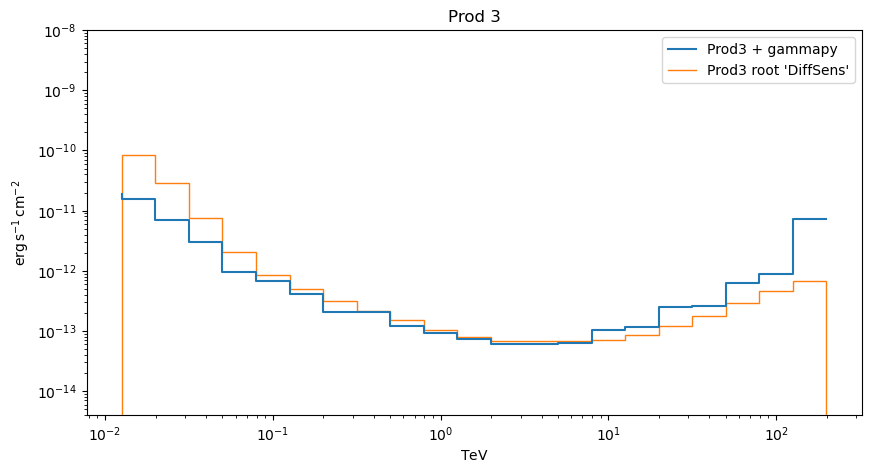

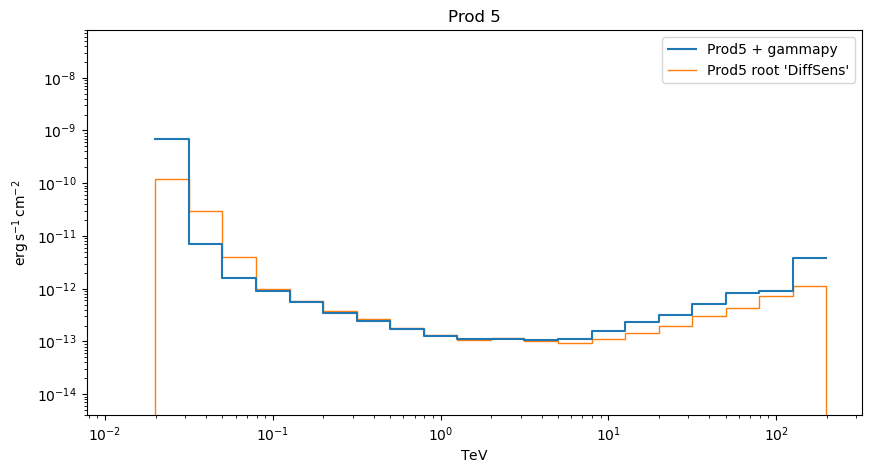

In [58]:
p3_gE, p3_gSens, _ = gp_sensitivity_curve(irf_tab_p3, p3_en, enclosure=True, conf={"point_offset": 0.0 * u.deg})
p5_gE, p5_gSens, tmp = gp_sensitivity_curve(irf_tab_p5, p5_en, enclosure=True, conf={"point_offset": 0.9 * u.deg})

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.step(p3_gE, p3_gSens, label="Prod3 + gammapy")
plt.stairs(prod3_sens, p3_en, label="Prod3 root 'DiffSens'")
plt.title("Prod 3")

plt.ylim(4e-15, 1e-8)
plt.loglog()
plt.legend()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.step(p5_gE, p5_gSens, label="Prod5 + gammapy")
plt.stairs(prod5_sens, p5_en, label="Prod5 root 'DiffSens'")
plt.title("Prod 5")

plt.ylim(4e-15, 8e-8)
plt.loglog()
plt.legend()

## Check function works also with pointlike irfs

In [54]:
irf_tab_p5_point["aeff"].is_pointlike, irf_tab_p5["aeff"].is_pointlike

(True, False)

In [55]:
irf_tab_p5_point["edisp"].is_pointlike, irf_tab_p5["edisp"].is_pointlike

(True, False)

In [56]:
irf_tab_p5_point["bkg"].is_pointlike, irf_tab_p5["bkg"].is_pointlike

(True, False)

/local/home/tb273079/miniconda3/envs/gp-sensitivity/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/local/home/tb273079/miniconda3/envs/gp-sensitivity/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


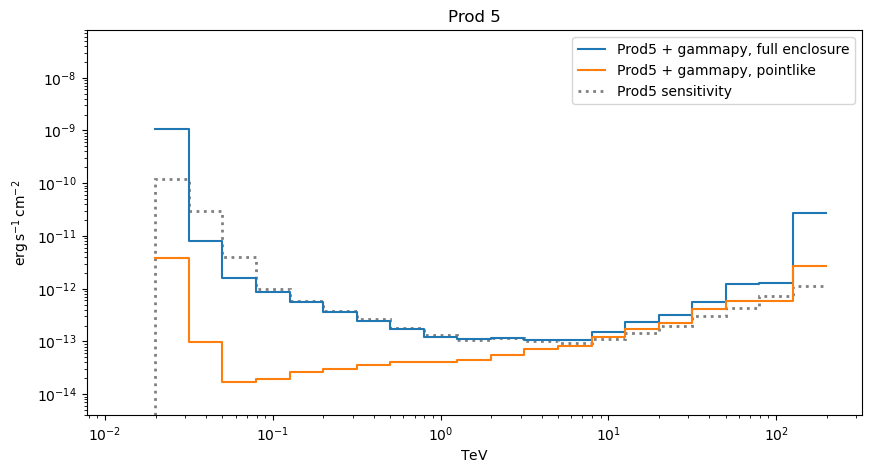

In [118]:
p5_gE, p5_gSens, _ = gp_sensitivity_curve(irf_tab_p5, p5_en, enclosure=True, conf={"point_offset": 0.5 * u.deg})
p5p_gE, p5p_gSens, _ = gp_sensitivity_curve(irf_tab_p5_point, p5_en, enclosure=False, conf={"point_offset": 0.5 * u.deg})

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.step(p5_gE, p5_gSens, label="Prod5 + gammapy, full enclosure")
plt.step(p5p_gE, p5p_gSens, label="Prod5 + gammapy, pointlike")
plt.stairs(prod5_sens, p5_en, label="Prod5 sensitivity", linestyle=":", color="k", lw=2, alpha=0.5, baseline=None)

plt.title("Prod 5")

plt.ylim(4e-15, 8e-8)
plt.loglog()
plt.legend()

/local/home/tb273079/miniconda3/envs/gp-sensitivity/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/local/home/tb273079/miniconda3/envs/gp-sensitivity/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


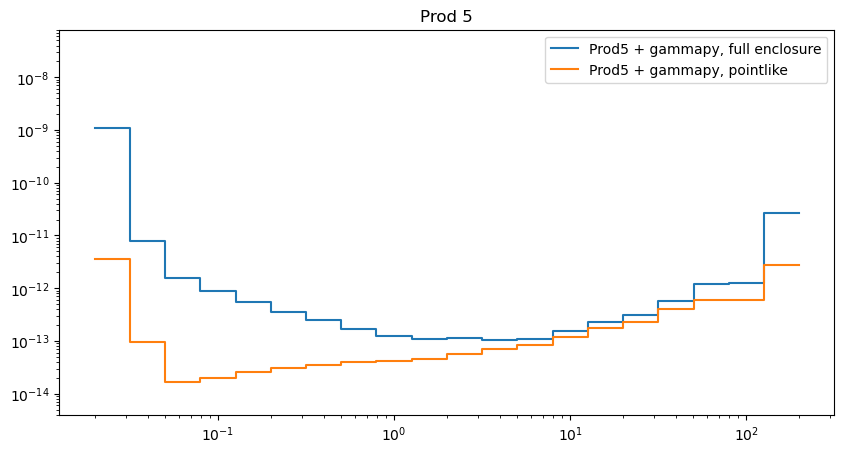

In [34]:
p5_gE, p5_gSens, _ = gp_sensitivity_curve(irf_tab_p5, p5_en, enclosure=True, conf={"point_offset": 0.5 * u.deg})
p5p_gE, p5p_gSens, _ = gp_sensitivity_curve(irf_tab_p5_point, p5_en, enclosure=False, conf={"point_offset": 0.5 * u.deg})

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.step(p5_gE, p5_gSens, label="Prod5 + gammapy, full enclosure")
plt.step(p5p_gE, p5p_gSens, label="Prod5 + gammapy, pointlike")

plt.title("Prod 5")

plt.ylim(4e-15, 8e-8)
plt.loglog()
plt.legend()

In [44]:
irf_test_disp = irf_tab_p5_point.copy()
tmp_tab = irf_tab_p5["edisp"].to_table()
irf_test_disp["edisp"] = EnergyDispersion2D.from_table(tmp_tab)

irf_test_bkg = irf_tab_p5_point.copy()
tmp_tab = irf_tab_p5["bkg"].to_table()
irf_test_bkg["bkg"] = Background3D.from_table(tmp_tab).to_2d()



/local/home/tb273079/miniconda3/envs/gp-sensitivity/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/local/home/tb273079/miniconda3/envs/gp-sensitivity/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


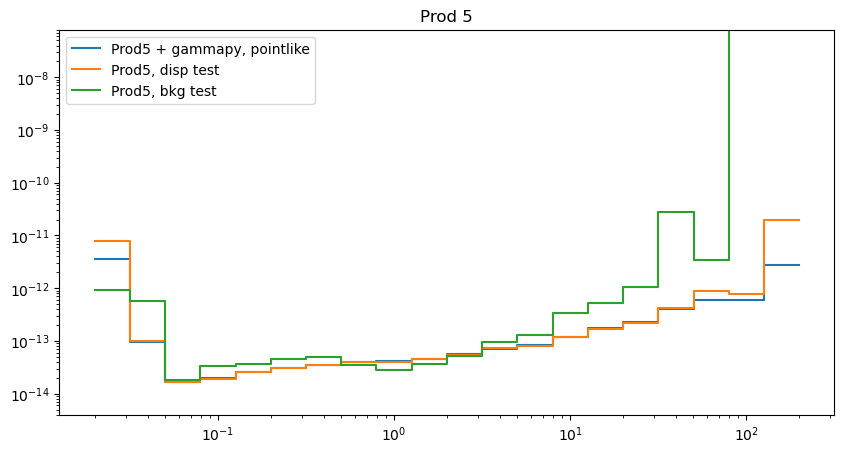

In [58]:
#p5p_gE, p5p_gSens, _ = gp_sensitivity_curve(irf_tab_p5_point, p5_en, enclosure=False, conf={"point_offset": 0.1 * u.deg})
p5_gE_disp, p5_gSens_disp, _ = gp_sensitivity_curve(irf_test_disp, p5_en, enclosure=False, conf={"point_offset": 0.1 * u.deg})
p5_gE_bkg, p5_gSens_bkg, _ = gp_sensitivity_curve(irf_test_bkg, p5_en, enclosure=False, conf={"point_offset": 0.1 * u.deg})

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#plt.step(p5p_gE, p5p_gSens, label="Prod5 + gammapy, pointlike")
plt.step(p5p_gE, p5p_gSens, label="Prod5 + gammapy, pointlike")
plt.step(p5_gE_disp, p5_gSens_disp, label="Prod5, disp test")
plt.step(p5_gE_bkg, p5_gSens_bkg, label="Prod5, bkg test")
#plt.step(py_gE, py_gSens, label="pyIRF + gammapy, pointlike")

plt.title("Prod 5")

plt.ylim(4e-15, 8e-8)
plt.loglog()
plt.legend()

### Compare enclosure with point like irfs

In [44]:
irf_tab_p5_point

{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x7fd21c5076b0>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x7fd21c415910>,
 'bkg': <gammapy.irf.background.Background2D at 0x7fd21babe300>,
 'rad_max': <gammapy.irf.rad_max.RadMax2D at 0x7fd21c53d880>}

In [20]:
irf_tab_p5_point["bkg"], irf_tab_p5["bkg"]

(<gammapy.irf.background.Background2D at 0x7f4dbc165670>,
 <gammapy.irf.background.Background3D at 0x7f4dbcbc5d30>)

#### Effective area

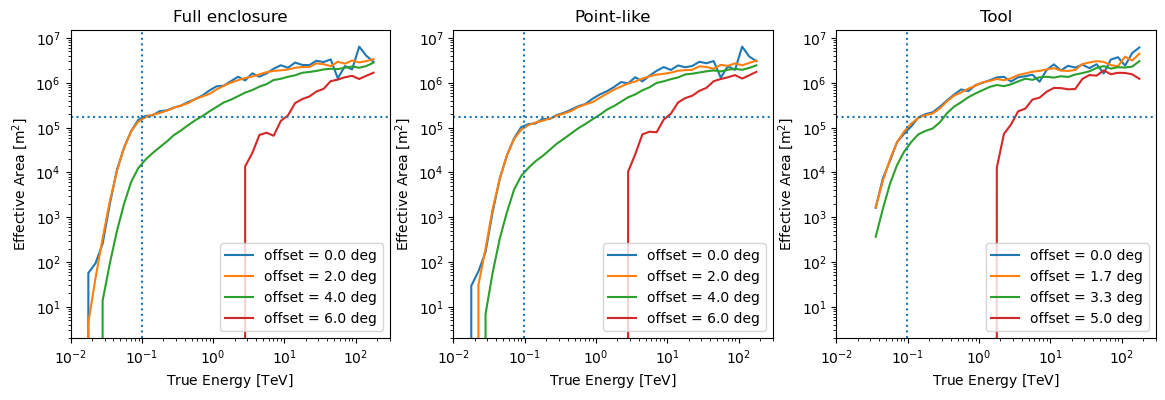

In [95]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
irf_tab_p5["aeff"].plot_energy_dependence(ax=axs[0])
axs[0].set(title="Full enclosure", yscale="log", xlim=(1e-2, 3e2), ylim=(2, 1.5e7))
axs[0].axvline(9.9e-2, linestyle=":")
axs[0].axhline(1.7e5, linestyle=":")
irf_tab_p5_point["aeff"].plot_energy_dependence(ax=axs[1])
axs[1].set(title="Point-like", yscale="log", xlim=(1e-2, 3e2), ylim=(2, 1.5e7))
axs[1].axvline(9.9e-2, linestyle=":")
axs[1].axhline(1.7e5, linestyle=":")
irf_tab_py["aeff"].plot_energy_dependence(ax=axs[2])
axs[2].set(title="Tool", yscale="log", xlim=(1e-2, 3e2), ylim=(2, 1.5e7))
axs[2].axvline(9.9e-2, linestyle=":")
axs[2].axhline(1.7e5, linestyle=":")

### Edisp

In [96]:
irf_tab_p5["edisp"]

[Text(0.5, 1.0, 'Tool')]

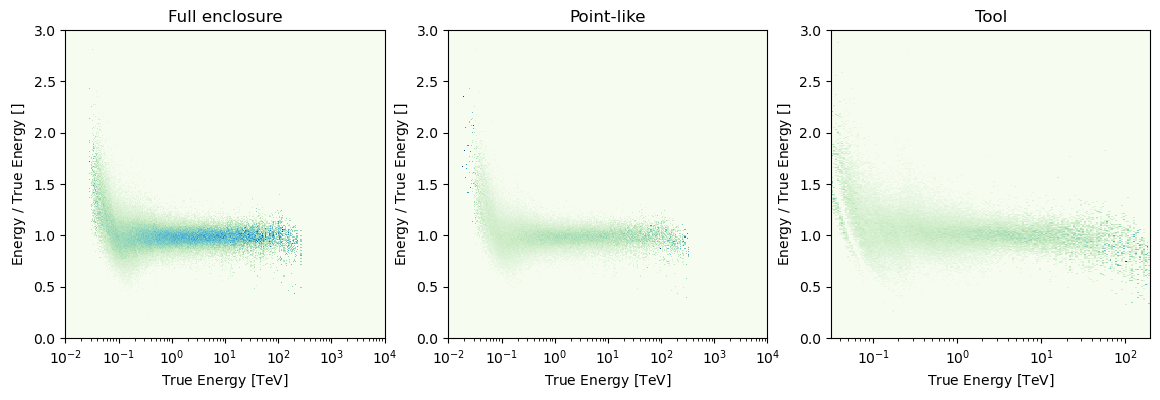

In [102]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
irf_tab_p5["edisp"].normalize()
irf_tab_p5["edisp"].plot_bias(ax=axs[0])
axs[0].set(title="Full enclosure")
irf_tab_p5_point["edisp"].normalize()
irf_tab_p5_point["edisp"].plot_bias(ax=axs[1])
axs[1].set(title="Point-like")
irf_tab_py["edisp"].normalize()
irf_tab_py["edisp"].plot_bias(ax=axs[2])
axs[2].set(title="Tool")

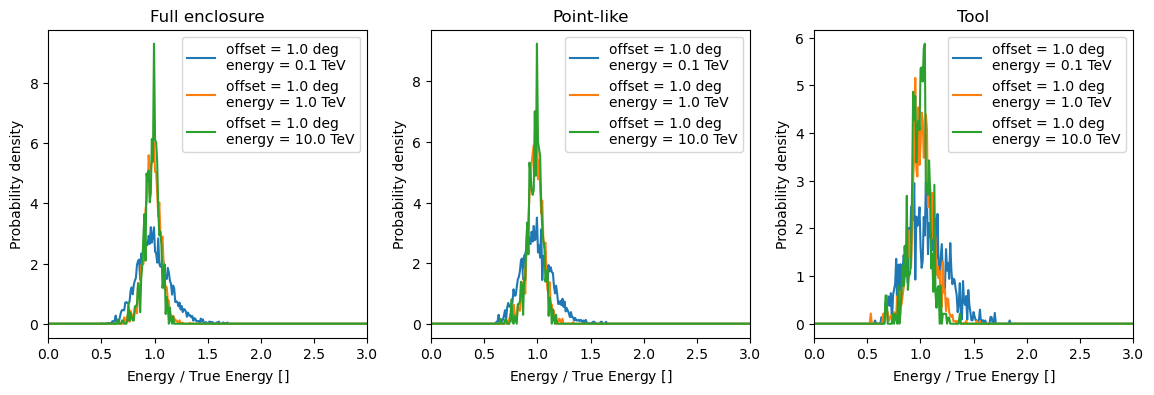

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
irf_tab_p5["edisp"].plot_migration(ax=axs[0])
axs[0].legend(loc="upper right")
axs[0].set(title="Full enclosure")

irf_tab_p5_point["edisp"].plot_migration(ax=axs[1])
axs[1].set(title="Point-like")
axs[1].legend(loc="upper right")

irf_tab_py["edisp"].plot_migration(ax=axs[2])
axs[2].set(title="Tool")
axs[2].legend(loc="upper right")

### Bkg

[Text(0.5, 1.0, 'Tool'), (0.01, 300.0), (1e-09, 0.3)]

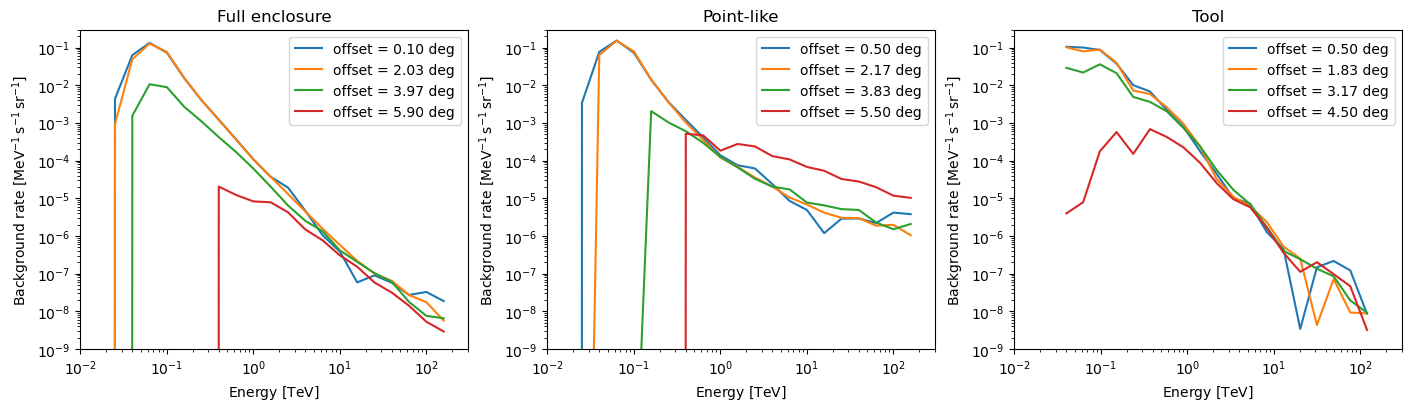

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.set_layout_engine("constrained")
irf_tab_p5["bkg"].to_2d().plot_energy_dependence(ax=axs[0])
axs[0].set(title="Full enclosure", xlim=(1e-2, 3e2), ylim=(1e-9, 3e-1))
irf_tab_p5_point["bkg"].plot_energy_dependence(ax=axs[1])
axs[1].set(title="Point-like", xlim=(1e-2, 3e2), ylim=(1e-9, 3e-1))
irf_tab_py["bkg"].plot_energy_dependence(ax=axs[2])
axs[2].set(title="Tool", xlim=(1e-2, 3e2), ylim=(1e-9, 3e-1))

[Text(0.5, 1.0, 'Tool'), (0.0, 6.0), (1e-09, 0.3)]

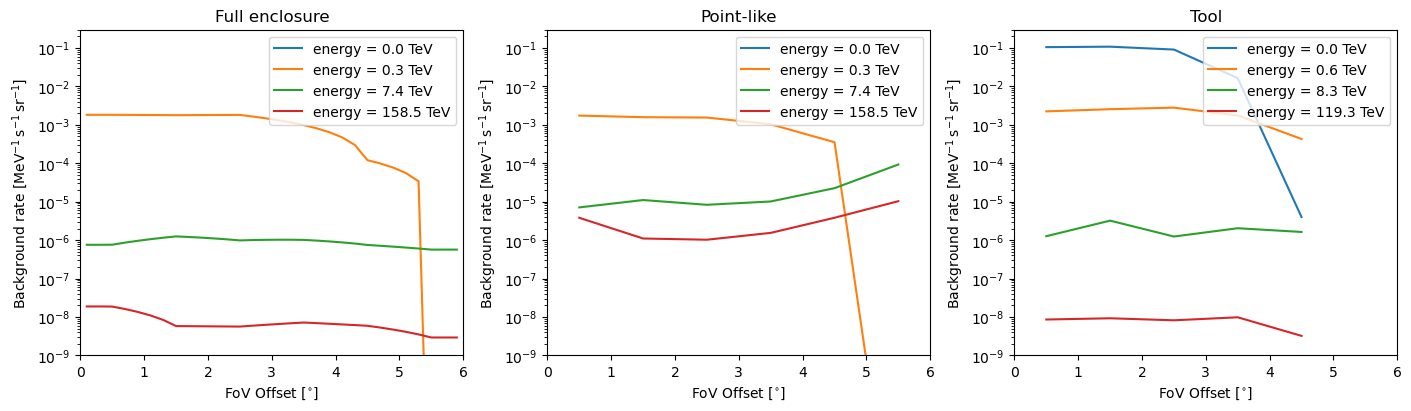

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.set_layout_engine("constrained")
irf_tab_p5["bkg"].to_2d().plot_offset_dependence(ax=axs[0])
axs[0].set(title="Full enclosure", xlim=(0, 6), ylim=(1e-9, 3e-1))
irf_tab_p5_point["bkg"].plot_offset_dependence(ax=axs[1])
axs[1].set(title="Point-like", xlim=(0, 6), ylim=(1e-9, 3e-1))
irf_tab_py["bkg"].plot_offset_dependence(ax=axs[2])
axs[2].set(title="Tool", xlim=(0, 6), ylim=(1e-9, 3e-1))

[Text(0.5, 1.0, 'full')]

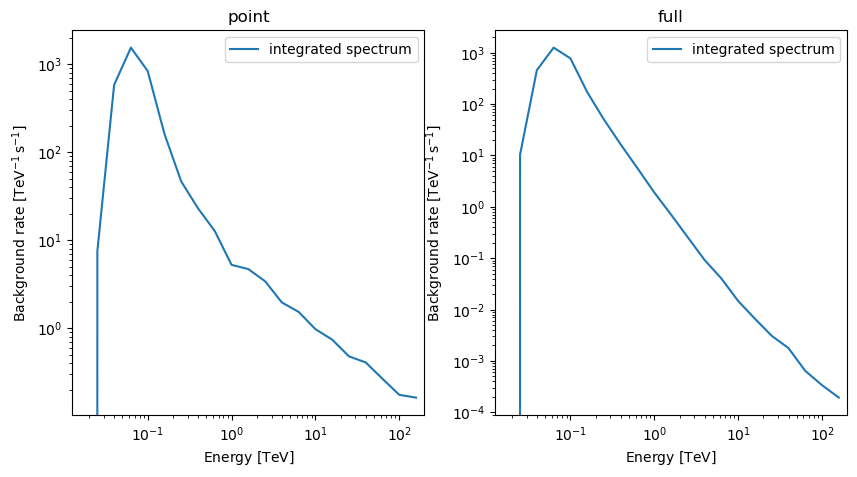

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
irf_tab_p5_point["bkg"].plot_spectrum(axs[0])
axs[0].set(title="point")
irf_test["bkg"].plot_spectrum(axs[1])
axs[1].set(title="full")


In [11]:
p5p_gE, p5p_gSens, _ = gp_sensitivity_curve(irf_tab_p5_point, p5_en, enclosure=False, conf={"point_offset": 0.1 * u.deg})
p5_gE, p5_gSens, _ = gp_sensitivity_curve(irf_test, p5_en, enclosure=False, conf={"point_offset": 0.1 * u.deg})
py_gE, py_gSens, _ = gp_sensitivity_curve(irf_tab_py, p5_en, enclosure=False, conf={"point_offset": 0.1 * u.deg})
py_gE, py_gSens, _ = gp_sensitivity_curve(irf_tab_py, p5_en, enclosure=False, conf={"point_offset": 0.1 * u.deg})

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.step(p5p_gE, p5p_gSens, label="Prod5 + gammapy, pointlike")
plt.step(p5_gE, p5_gSens, label="Prod5 + gammapy, test")
#plt.step(py_gE, py_gSens, label="pyIRF + gammapy, pointlike")

plt.title("Prod 5")

plt.ylim(4e-15, 8e-8)
plt.loglog()
plt.legend()

NameError: name 'irf_test' is not defined

# Misc checks

[]

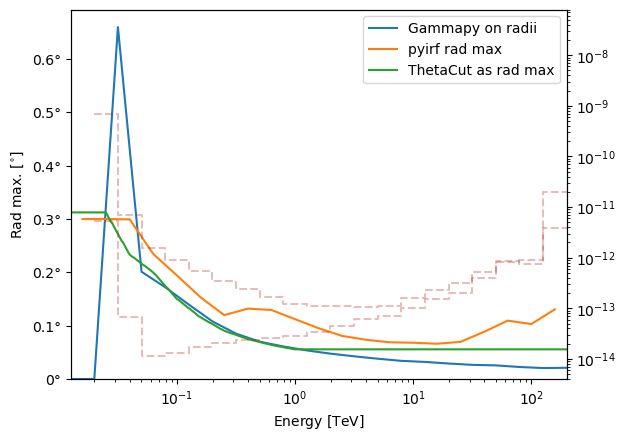

In [81]:
fig, ax = plt.subplots()
ax.plot(p5_gE, tmp[1], label="Gammapy on radii")
irf_tab_py["rad_max"].plot_rad_max_vs_energy(ax=ax, label="pyirf rad max")
irf_tab_p5["rad_max"].plot_rad_max_vs_energy(ax=ax, label="ThetaCut as rad max")
ax2 = ax.twinx()
ax2.step(py_gE, py_gSens, label="pyIRF + gammapy, pointlike",color="firebrick",linestyle="dashed", alpha=0.3)
ax2.step(p5_gE, p5_gSens, label="pyIRF + gammapy, pointlike",color="firebrick",linestyle="dashed", alpha=0.3)
ax2.set(ylim=(4e-15, 8e-8), yscale="log")
plt.semilogx()